In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import utils.Convnet_Functions as CF

data_dir='/mnt/storage/home/robert/Convnet_Classifier/Convnet_Classifier/data/Ventricles_Regression/Trains'
test_dir='/mnt/storage/home/robert/Convnet_Classifier/Convnet_Classifier/data/Ventricles_Regression/Tests'

train_data=[]                               #images
train_labels=[]                             #labels
test_data=[]
test_labels=[]

for file in os.listdir(data_dir):
    data=np.load(os.path.join(data_dir,file), allow_pickle=True)
    train_data.append((data[0][0]))
    train_labels.append(data[0][1])

train_data = torch.tensor(train_data)
train_labels = torch.tensor(train_labels)
train_data = train_data.float()

for file in os.listdir(test_dir):
    data=np.load(os.path.join(test_dir,file), allow_pickle=True)
    test_data.append((data[0][0]))
    test_labels.append(data[0][1])

test_data = torch.tensor(test_data)
test_labels = torch.tensor(test_labels)
test_data = test_data.float()

train_sh = train_data.size()
test_sh = test_data.size()

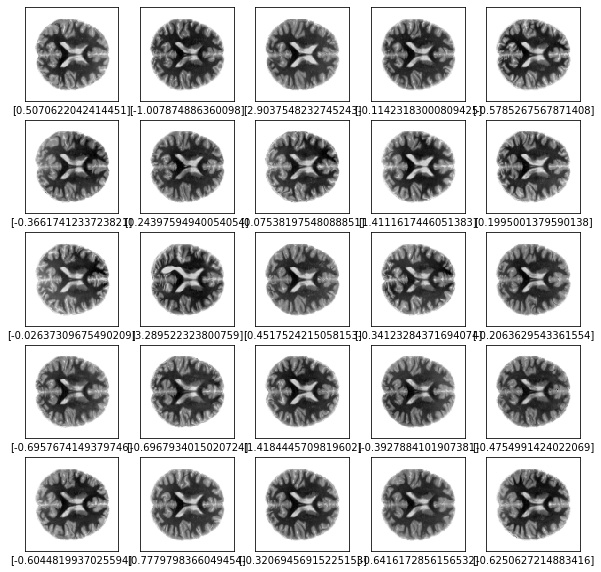

In [2]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_data[i,:,:,60], cmap=plt.cm.binary)
    plt.xlabel([float(train_labels[i][0])])
plt.show()

## Define Model

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
                nn.Conv3d(1, 32, 5, stride=2),
                nn.ReLU(),
                nn.BatchNorm3d(32),
                nn.LeakyReLU(),
                nn.MaxPool3d(3, stride=2))
        self.conv2 = nn.Sequential(
                nn.Conv3d(32, 64, 5, stride=2),
                nn.ReLU(),
                nn.BatchNorm3d(64),
                nn.LeakyReLU(),
                nn.MaxPool3d(2, stride=2),
                nn.Dropout(0.5))
        self.fc1 = nn.Sequential(
                nn.Linear(64*5*5*6, 64*5*5),
                nn.LeakyReLU(),
                nn.Dropout(0.4))
        self.fc2 = nn.Sequential(
                nn.Linear(64*5*5, 64*5),
                nn.LeakyReLU(),
                nn.Dropout(0.3))
        self.fc3 = nn.Sequential(
                nn.Linear(64*5, 1))
        
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        
        x = torch.flatten(x, start_dim=1)
        xsh = x.size(-1)
        x = x.view(-1,xsh)
        
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        
        return x

In [4]:
loss_function = nn.MSELoss()

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

In [6]:
net = Net().to(device)

## We will define fwd_pass and deal with BATCH later

In [7]:
def fwd_pass(x, y, train=False):
    if train:
        net.zero_grad()
    outputs = net(x)
    matches = [torch.argmax(i) == torch.argmax(j) for i,j in zip(outputs, y)]
    acc = matches.count(True)/len(matches)
    loss = loss_function(outputs, y)
    
    if train:
        loss.backward()
        optimizer.step()
    return acc, loss

In [8]:
def test(size=1):
    random_start = np.random.randint(len(test_data) - size)
    #Take a random selection of test data
    X, Y = test_data[random_start:random_start+size], test_labels[random_start:random_start+size].float()
    val_acc, val_loss = fwd_pass(X.view(size,-1,106,106,120).to(device),Y.to(device))
    
    return val_acc, val_loss

val_acc, val_loss = test(size=1)
print(val_acc, val_loss)

1.0 tensor(1.0550, device='cuda:0', grad_fn=<MseLossBackward>)


In [9]:
import time
import torch.optim as optim
from tqdm import tqdm

MODEL_NAME = f"Diffusion-Regressor-{int(time.time())}"
optimizer = optim.Adam(net.parameters(), lr=0.00000001)
loss_function = nn.MSELoss()

print(MODEL_NAME)

def train(epochs):
    BATCH_SIZE = 10
    EPOCHS = epochs
    
    with open("model.log", "a") as f:
        for epoch in range(epochs):
            for i in tqdm(range(0,len(train_data), BATCH_SIZE)):
                feed = min(BATCH_SIZE, len(train_data)-i)
                batch_data = train_data[i:i+feed].view(feed,1,106,106,120).to(device)
                batch_labels = train_labels[i:i+feed].float().to(device)
                
                acc, loss = fwd_pass(batch_data, batch_labels, train=True)
                if i % 50 == 0:
                    val_acc, val_loss = test(size=feed)
                    f.write(f"{MODEL_NAME},{round(time.time(),3)}, {round(float(acc),2)}, {round(float(loss),4)}, {round(float(val_acc),2)}, {round(float(val_loss),4)}\n")

Diffusion-Regressor-1594222085


In [10]:
train(100)

100%|██████████| 27/27 [00:04<00:00,  6.39it/s]


In [11]:
test()

(1.0, tensor(0.8855, device='cuda:0', grad_fn=<MseLossBackward>))

In [39]:
import math
math.log(93,2.8)

4.402208638957476

In [42]:
93**(1/2.8)

5.046957231453498